# Data Loading

In [1]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import scipy.io
import matplotlib.pyplot as plt

## Binary Alpha Digits

In [260]:
import os
data_folder = './data'
for dirname, _, filenames in os.walk(data_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data\binaryalphadigs.mat
./data\fashionmnist-dataset\train-images-idx3-ubyte
./data\mnist-dataset\train-images.idx3-ubyte


In [261]:
data_binaryalphadigits = os.path.join(data_folder, 'binaryalphadigs.mat')
data = scipy.io.loadmat(data_binaryalphadigits)

In [262]:
def load_data(data_folder=data_folder, file='binaryalphadigs.mat'):
    data_file = os.path.join(data_folder, file)

    data = scipy.io.loadmat(data_binaryalphadigits)
    images = data['dat']
    height, width = images[0][0].shape

    # Flatten all images across all classes (0-35: 10 digits + 26 letters)
    flattened_images = []
    for class_images in images:  # Iterate over each class
        for img in class_images:  # Iterate over images in the class
            flattened_images.append(img.flatten())

    # Convert to a tensor
    image_tensor = torch.tensor(np.array(flattened_images), dtype=torch.float32)

    return image_tensor, images, height, width

In [263]:
# Convert to a tensor
image_tensor, images, height, width = load_data()

print(f"Tensor shape: {image_tensor.shape}")

Tensor shape: torch.Size([1404, 320])


In [264]:
images.shape

(36, 39)

In [265]:
import random

def display_image(images, num_images=5):
    # Randomly select indices for the images
    random_indices = random.sample(range(len(images)), num_images)
    
    # Set up a grid for the images
    fig, axes = plt.subplots(1, num_images, figsize=(5, 5))
    
    # Loop through the random indices and display each image
    for i, idx in enumerate(random_indices):
        image = images[idx].reshape(20, 16)  # Reshape the image to 20x16 if needed
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Image {idx}')
        axes[i].axis('off')  # Hide the axes
    
    plt.tight_layout()
    plt.show()

In [222]:
image_tensor.shape

torch.Size([1404, 320])

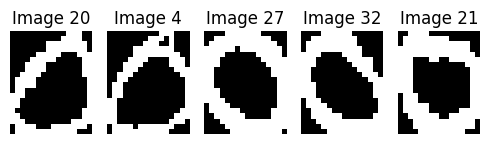

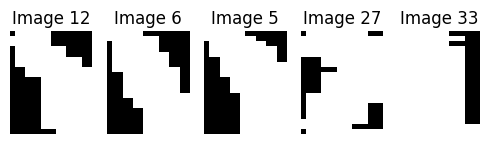

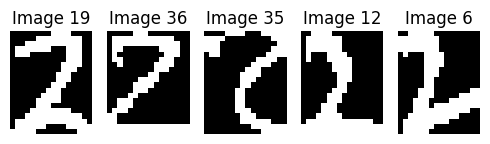

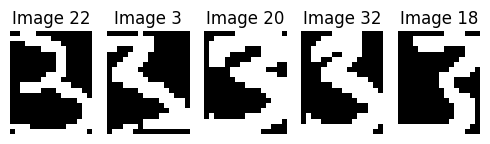

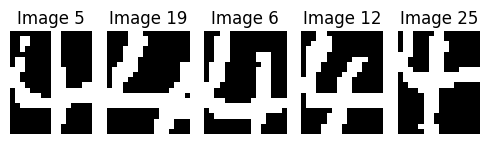

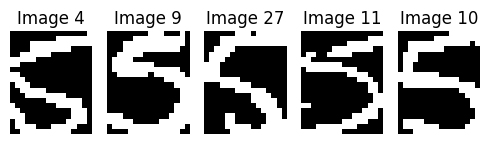

In [266]:
display_image(images[0])
display_image(images[1])
display_image(images[2])
display_image(images[3])
display_image(images[4])
display_image(images[5])

#### Lire Alpha Digit

In [306]:
def lire_alpha_digit(data,list_):
    """
    """
    X=data['dat'][list_[0]]
    len_ = len(list_)

    for i in range(1,len_) :
        X_i = data['dat'][list_[i]]
        X = np.concatenate((X,X_i),axis=0)

    n = X.shape[0]
    X = np.concatenate(X).reshape((n,320))
    return X

In [225]:
output = lire_alpha_digit(data, [1, 2, 3])

In [226]:
output.shape

(117, 320)

# Model

## Definition

In [299]:
import copy 
from tqdm import tqdm

class RBM(nn.Module):

    def __init__(self, p: int, q:int, img_size: tuple[int, int]):
        super(RBM, self).__init__()
        self.p = p
        self.q = q
        self.height= img_size[0]
        self.width= img_size[1]

        # Notes:
        # nn.Parameters automatically adds the variable to the list of the model's parameters
        # nn.Parameter tells Pytorch to include this tensor in the computation graph and compute gradients for it during backprop
        # nn.Parameter allow params to move to the right devide when appluing .to(device)

        # Parameters
        self.W = nn.Parameter(torch.randn(q, p)*1e-2)

        # Bias - initialised at 0
        self.a = nn.Parameter(torch.zeros(p))
        self.b = nn.Parameter(torch.zeros(q))

    def entree_sortie(self, v):
        # F.linear performs: v.W + b
        sigm = torch.sigmoid(F.linear(v, self.W, self.b))
        return sigm

    def sortie_entree(self, h):
        # F.linear performs: h.W(transpose) + a
        sigm = torch.sigmoid(F.linear(h, self.W.t(), self.a))
        return sigm

    def forward(self, v):
        raise NotImplementedError("Use the train method for training the RBM.")

    def train(self, V, nb_epoch, batch_size, eps=0.001, verbose=True):
        """
        Train the RBM using Contrastive Divergence

        Args:
        - V: input data
        - nb_epoch: Number of epoch
        - batch_size: Batch size
        - eps: Learning rate
        """
        n = V.size(0)
        p, q = self.p, self.q
        losses = []

        for epoch in range(nb_epoch):
            # Shuffle dataset
            V = V[torch.randperm(n)]
            
            # Iterate with batch_size step
            for j in range(0, n, batch_size):
                V_batch = V[j:min(j + batch_size, n)]
                batch_size_actual = V_batch.size(0)

                v_0 = copy.deepcopy(V_batch)
                p_h_v_0 = self.entree_sortie(v_0)
                # Sample
                h_0 = (torch.rand(batch_size_actual, q) < p_h_v_0).float()
                
                p_v_h_0 = self.sortie_entree(h_0)
                v_1 = (torch.rand(batch_size_actual, p) < p_v_h_0).float()
                
                p_h_v_1 = self.entree_sortie(v_1)

                # grad
                grad_a = torch.sum(v_0 - v_1, dim=0)
                grad_b = torch.sum(p_h_v_0 - p_h_v_1, dim=0)
                grad_W = torch.matmul(v_0.t(), p_h_v_0) - torch.matmul(v_1.t(), p_h_v_1)

                # Update params - Normalise to batch size
                # Note: We bypass the pytorch computation graph with .data to avoid accumulating gradients
                self.W.data += eps * grad_W.t() / batch_size_actual
                self.b.data += eps * grad_b / batch_size_actual
                self.a.data += eps * grad_a / batch_size_actual

            quad_error = self.reconstruction_error(V)
            
            losses.append(quad_error.item())
            if verbose and epoch%10==0:
                print(f"Epoch {epoch+1}/{nb_epoch}, Reconstruction Error (EQ): {quad_error.item():.6f}")
        
        self.losses = losses
        self.nb_epoch = nb_epoch

        if verbose:
            self.plot_loss()
            print(f"Final loss: {self.losses[-1]}")

        return losses

    def generer_image_RBM(self, num_iterations, num_images):
        """
        Generate samples from an RBM using Gibbs sampling.

        Args:
            rbm (RBM): The RBM object.
            num_iterations (int): Number of Gibbs sampling steps to use.
            num_images (int): Number of images to generate.

        Returns:
            torch.Tensor: A tensor of generated images.
        """
        # Initialize random visible states
        generated_images = torch.bernoulli(torch.rand(num_images, self.p))  # Random binary states

        # Perform Gibbs sampling
        for _ in range(num_iterations):
            # Sample hidden states given visible states
            p_h_given_v = self.entree_sortie(generated_images)
            h = (torch.rand_like(p_h_given_v) < p_h_given_v).float()

            # Sample visible states given hidden states
            p_v_given_h = self.sortie_entree(h)
            generated_images = (torch.rand_like(p_v_given_h) < p_v_given_h).float()

        print(f"Infos on generated_images:")
        print(f"type: {type(generated_images)}")
        print(f"size: {generated_images.size()}")

        # Plot the generated images
        _, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
        for i, ax in enumerate(axes):
            ax.imshow(generated_images[i].view(self.height, self.width), cmap="gray")
            ax.axis("off")

        plt.show()

        return generated_images
    
    def save_generated_images(self, generated_images: torch.Tensor, path: str, title=None) -> None:

        num_images = generated_images.shape[0]

        # Plot the generated images
        _, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
        for i, ax in enumerate(axes):
            ax.imshow(generated_images[i].view(self.height, self.width), cmap="gray")
            ax.axis("off")

        if title is not None:
            plt.suptitle(title)

        plt.savefig(path)
    
    def plot_loss(self):

        if not hasattr(self, "losses"):
            raise AttributeError("The attribute 'losses' is missing. Make sure to initialize it in runing the train() method before calling plot().")
        
        plt.plot(self.losses)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.title(f'Loss | {self.nb_epoch} epochs')
        plt.show()

    def reconstruction_error(self, V: torch.Tensor, return_float=False) -> torch.Tensor | float:
        """Compute the reconstruction error on a set of tensor images"""
        n = V.size(0)
        H = self.entree_sortie(V)
        V_rec = self.sortie_entree(H)
        torch_sum = torch.sum((V - V_rec)**2) / (n*self.p)
        if return_float:
            return float(torch_sum.item())
        return torch_sum




## Training

In [301]:
rbm = RBM(p=image_tensor.size(1), q=64, img_size=(height, width))

In [76]:
def train_rbm_on_dataset(rbm: RBM, data_folder, dataset='binaryalphadigs.mat', nb_epoch=1000, batch_size=10, eps=1e-2, p=256, q=128, verbose=True):
    """
    Function to train the RBM model on the given dataset of binary images.

    Args:
    - data_folder: Path to the folder containing the 'binaryalphadigs.mat' file.
    - nb_epoch: Number of training epochs.
    - batch_size: Batch size for training.
    - eps: Learning rate for gradient update.
    - p: Number of visible units.
    - q: Number of hidden units.
    """
    
    # Load the dataset
    image_tensor, images, height, width = load_data(data_folder, dataset)

    # Normalize the data (if necessary)
    # Assuming the data is binary, no need to scale between 0 and 1 but if it isn't, you can scale it:
    # image_tensor = image_tensor / 255.0  # If data isn't binary, you can normalize

    # Initialize RBM model
    

    # Train the RBM
    rbm.train(image_tensor, nb_epoch=nb_epoch, batch_size=batch_size, eps=eps, verbose=verbose)

    print("Training complete.")

In [ ]:
train_rbm_on_dataset(rbm, data_folder=data_folder)

## Test

In [ ]:
# Assume rbm is a trained RBM object
generated_images = rbm.generer_image_RBM(num_iterations=100000, num_images=10)

# Study

### 1. hyperparameters variations

#### - Number of hidden unities

Epoch 1/400, Reconstruction Error (EQ): 0.226991
Epoch 11/400, Reconstruction Error (EQ): 0.185522
Epoch 21/400, Reconstruction Error (EQ): 0.168249
Epoch 31/400, Reconstruction Error (EQ): 0.159056
Epoch 41/400, Reconstruction Error (EQ): 0.153004
Epoch 51/400, Reconstruction Error (EQ): 0.148884
Epoch 61/400, Reconstruction Error (EQ): 0.145944
Epoch 71/400, Reconstruction Error (EQ): 0.143975
Epoch 81/400, Reconstruction Error (EQ): 0.142630
Epoch 91/400, Reconstruction Error (EQ): 0.141480
Epoch 101/400, Reconstruction Error (EQ): 0.140671
Epoch 111/400, Reconstruction Error (EQ): 0.140023
Epoch 121/400, Reconstruction Error (EQ): 0.139443
Epoch 131/400, Reconstruction Error (EQ): 0.138965
Epoch 141/400, Reconstruction Error (EQ): 0.138708
Epoch 151/400, Reconstruction Error (EQ): 0.138473
Epoch 161/400, Reconstruction Error (EQ): 0.138341
Epoch 171/400, Reconstruction Error (EQ): 0.138192
Epoch 181/400, Reconstruction Error (EQ): 0.138164
Epoch 191/400, Reconstruction Error (EQ): 

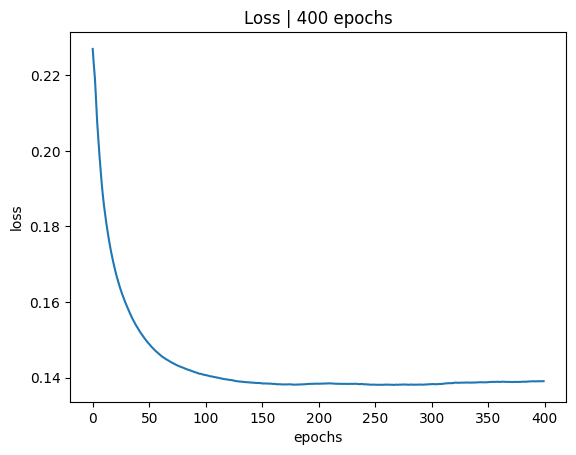

Final loss: 0.13905884325504303
Epoch 1/400, Reconstruction Error (EQ): 0.225860
Epoch 11/400, Reconstruction Error (EQ): 0.167652
Epoch 21/400, Reconstruction Error (EQ): 0.148121
Epoch 31/400, Reconstruction Error (EQ): 0.136406
Epoch 41/400, Reconstruction Error (EQ): 0.128791
Epoch 51/400, Reconstruction Error (EQ): 0.123598
Epoch 61/400, Reconstruction Error (EQ): 0.120114
Epoch 71/400, Reconstruction Error (EQ): 0.117487
Epoch 81/400, Reconstruction Error (EQ): 0.115353
Epoch 91/400, Reconstruction Error (EQ): 0.113839
Epoch 101/400, Reconstruction Error (EQ): 0.112537
Epoch 111/400, Reconstruction Error (EQ): 0.111567
Epoch 121/400, Reconstruction Error (EQ): 0.110794
Epoch 131/400, Reconstruction Error (EQ): 0.110078
Epoch 141/400, Reconstruction Error (EQ): 0.109474
Epoch 151/400, Reconstruction Error (EQ): 0.108921
Epoch 161/400, Reconstruction Error (EQ): 0.108486
Epoch 171/400, Reconstruction Error (EQ): 0.108110
Epoch 181/400, Reconstruction Error (EQ): 0.107753
Epoch 191/

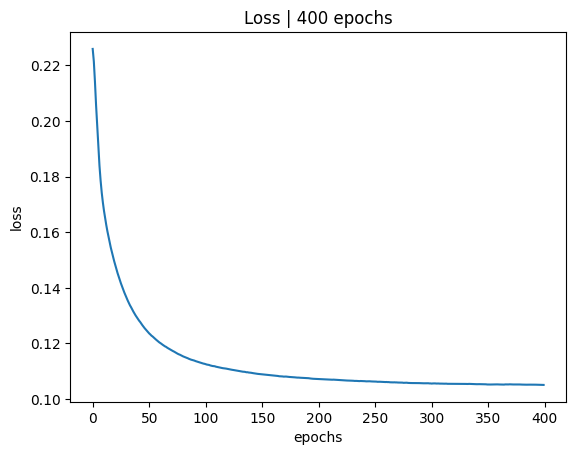

Final loss: 0.10509899258613586
Epoch 1/400, Reconstruction Error (EQ): 0.225287
Epoch 11/400, Reconstruction Error (EQ): 0.149980
Epoch 21/400, Reconstruction Error (EQ): 0.123969
Epoch 31/400, Reconstruction Error (EQ): 0.109564
Epoch 41/400, Reconstruction Error (EQ): 0.101735
Epoch 51/400, Reconstruction Error (EQ): 0.096378
Epoch 61/400, Reconstruction Error (EQ): 0.092384
Epoch 71/400, Reconstruction Error (EQ): 0.089372
Epoch 81/400, Reconstruction Error (EQ): 0.086868
Epoch 91/400, Reconstruction Error (EQ): 0.084913
Epoch 101/400, Reconstruction Error (EQ): 0.083158
Epoch 111/400, Reconstruction Error (EQ): 0.081729
Epoch 121/400, Reconstruction Error (EQ): 0.080519
Epoch 131/400, Reconstruction Error (EQ): 0.079376
Epoch 141/400, Reconstruction Error (EQ): 0.078520
Epoch 151/400, Reconstruction Error (EQ): 0.077720
Epoch 161/400, Reconstruction Error (EQ): 0.077043
Epoch 171/400, Reconstruction Error (EQ): 0.076370
Epoch 181/400, Reconstruction Error (EQ): 0.075777
Epoch 191/

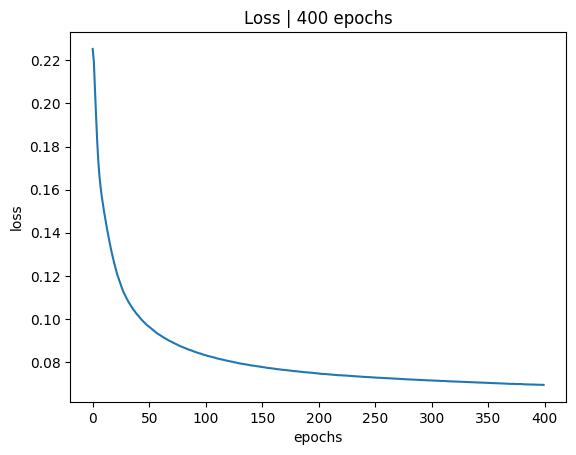

Final loss: 0.06942284852266312
Epoch 1/400, Reconstruction Error (EQ): 0.225656
Epoch 11/400, Reconstruction Error (EQ): 0.131774
Epoch 21/400, Reconstruction Error (EQ): 0.101680
Epoch 31/400, Reconstruction Error (EQ): 0.088046
Epoch 41/400, Reconstruction Error (EQ): 0.079521
Epoch 51/400, Reconstruction Error (EQ): 0.073684
Epoch 61/400, Reconstruction Error (EQ): 0.069262
Epoch 71/400, Reconstruction Error (EQ): 0.065647
Epoch 81/400, Reconstruction Error (EQ): 0.062900
Epoch 91/400, Reconstruction Error (EQ): 0.060287
Epoch 101/400, Reconstruction Error (EQ): 0.058249
Epoch 111/400, Reconstruction Error (EQ): 0.056381
Epoch 121/400, Reconstruction Error (EQ): 0.054733
Epoch 131/400, Reconstruction Error (EQ): 0.053278
Epoch 141/400, Reconstruction Error (EQ): 0.051955
Epoch 151/400, Reconstruction Error (EQ): 0.050790
Epoch 161/400, Reconstruction Error (EQ): 0.049719
Epoch 171/400, Reconstruction Error (EQ): 0.048786
Epoch 181/400, Reconstruction Error (EQ): 0.047863
Epoch 191/

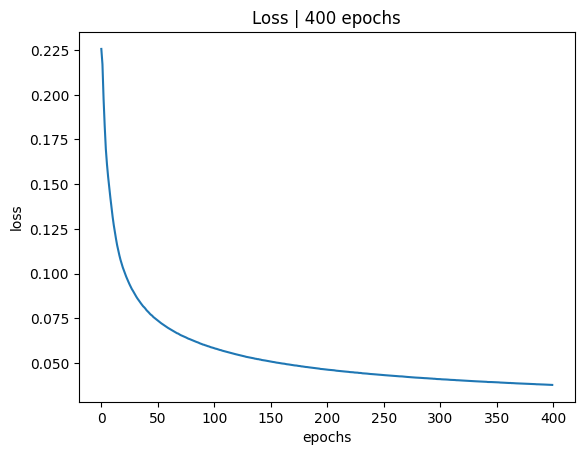

Final loss: 0.037730563431978226
Epoch 1/400, Reconstruction Error (EQ): 0.227857
Epoch 11/400, Reconstruction Error (EQ): 0.111287
Epoch 21/400, Reconstruction Error (EQ): 0.084364
Epoch 31/400, Reconstruction Error (EQ): 0.070322
Epoch 41/400, Reconstruction Error (EQ): 0.061785
Epoch 51/400, Reconstruction Error (EQ): 0.055284
Epoch 61/400, Reconstruction Error (EQ): 0.050289
Epoch 71/400, Reconstruction Error (EQ): 0.046451
Epoch 81/400, Reconstruction Error (EQ): 0.043326
Epoch 91/400, Reconstruction Error (EQ): 0.040530
Epoch 101/400, Reconstruction Error (EQ): 0.038167
Epoch 111/400, Reconstruction Error (EQ): 0.035995
Epoch 121/400, Reconstruction Error (EQ): 0.034187
Epoch 131/400, Reconstruction Error (EQ): 0.032375
Epoch 141/400, Reconstruction Error (EQ): 0.030836
Epoch 151/400, Reconstruction Error (EQ): 0.029437
Epoch 161/400, Reconstruction Error (EQ): 0.028154
Epoch 171/400, Reconstruction Error (EQ): 0.026994
Epoch 181/400, Reconstruction Error (EQ): 0.025911
Epoch 191

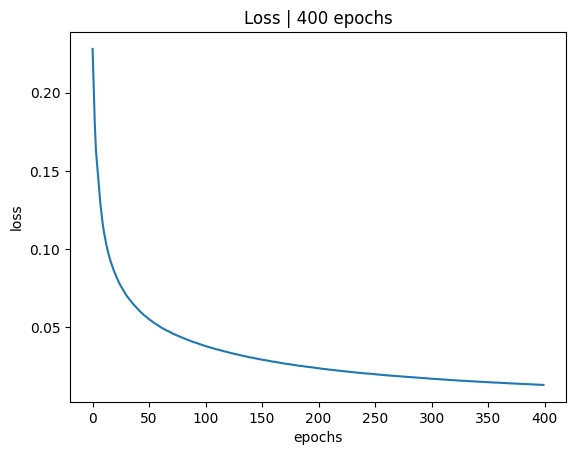

Final loss: 0.013318097218871117


In [ ]:
image_tensor, images, height, width = load_data(data_folder, 'binaryalphadigs.mat')

trained_rbm = []

for q in [16, 32, 64, 128, 256]:

    rbm = RBM(p=image_tensor.size(1), q=q, img_size=(height, width))
    rbm.train(image_tensor, nb_epoch=400, batch_size=10, eps=1e-2, verbose=True)
    trained_rbm.append({"q":q, "rbm": rbm})


Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


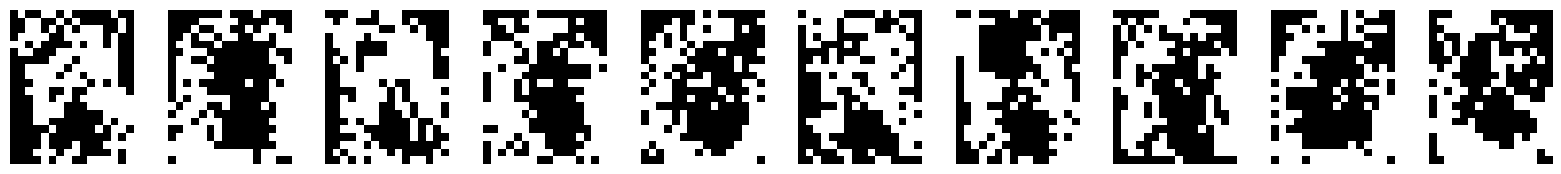

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


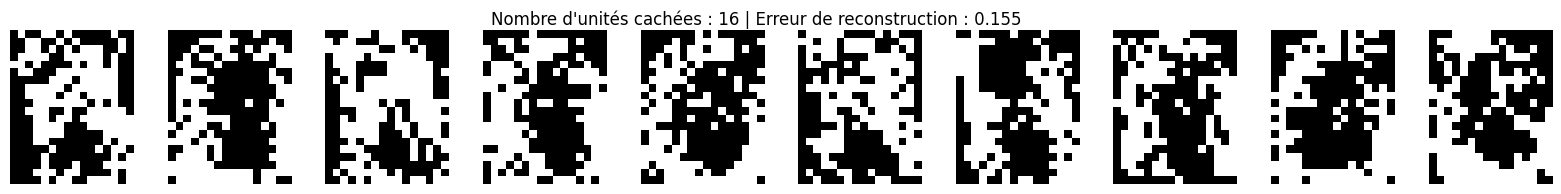

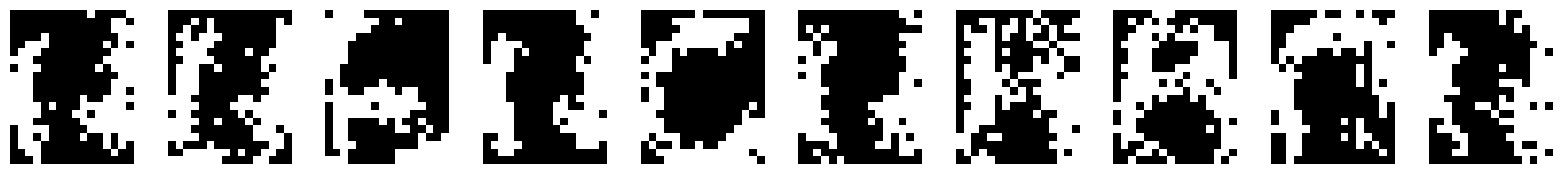

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


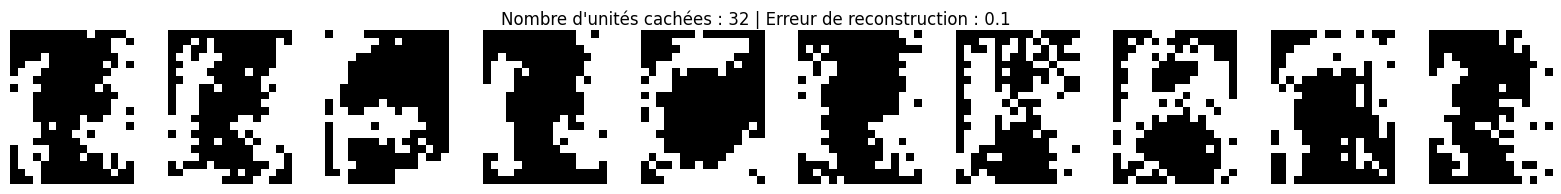

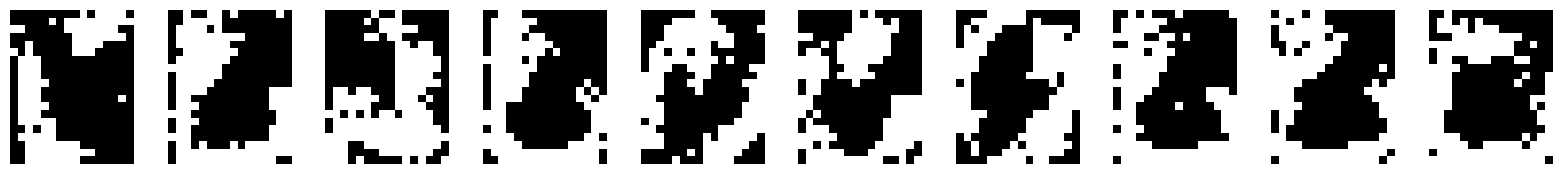

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


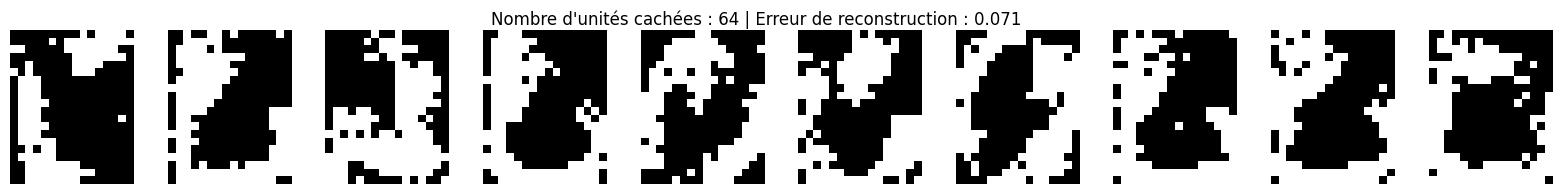

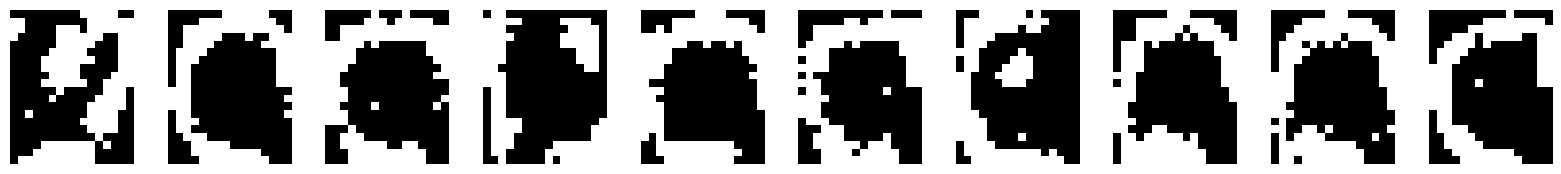

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


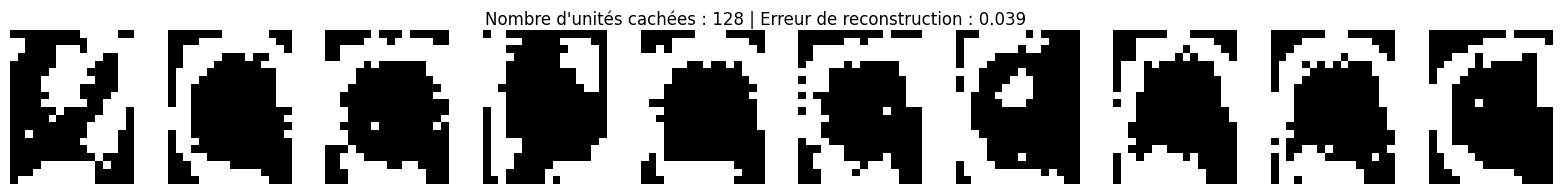

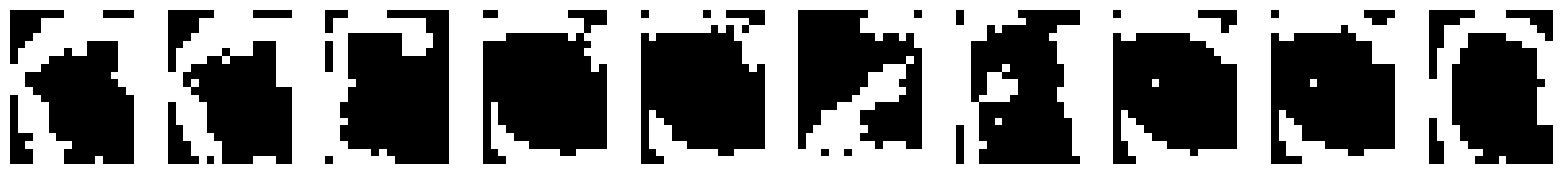

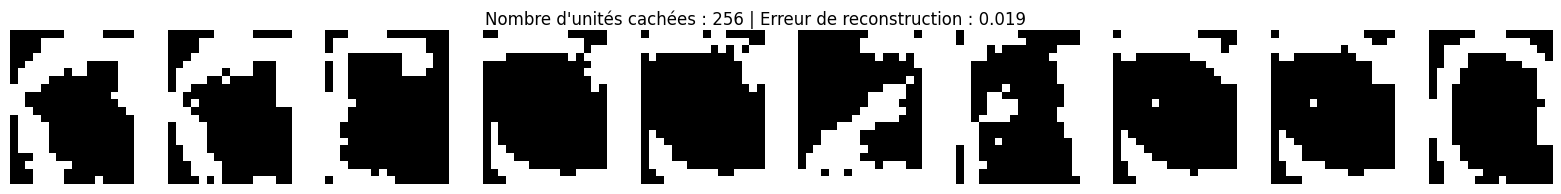

In [131]:
for q_rbm in trained_rbm:
    q = q_rbm["q"]
    rbm: RBM = q_rbm["rbm"]

    print(f">>>>> q = {q}")

    generated_images = rbm.generer_image_RBM(num_iterations=100000, num_images=10)
    error = rbm.reconstruction_error(generated_images, return_float=True)
    rbm.save_generated_images(generated_images, path=f"assets/rbm_q_{q}.png", title=f"Nombre d'unités cachées : {q} | Erreur de reconstruction : {round(error, 3)}")

#### - batch size

Epoch 1/400, Reconstruction Error (EQ): 0.161131
Epoch 11/400, Reconstruction Error (EQ): 0.064283
Epoch 21/400, Reconstruction Error (EQ): 0.052676
Epoch 31/400, Reconstruction Error (EQ): 0.047150
Epoch 41/400, Reconstruction Error (EQ): 0.044161
Epoch 51/400, Reconstruction Error (EQ): 0.041809
Epoch 61/400, Reconstruction Error (EQ): 0.040001
Epoch 71/400, Reconstruction Error (EQ): 0.038750
Epoch 81/400, Reconstruction Error (EQ): 0.037559
Epoch 91/400, Reconstruction Error (EQ): 0.036694
Epoch 101/400, Reconstruction Error (EQ): 0.035998
Epoch 111/400, Reconstruction Error (EQ): 0.035473
Epoch 121/400, Reconstruction Error (EQ): 0.034924
Epoch 131/400, Reconstruction Error (EQ): 0.034354
Epoch 141/400, Reconstruction Error (EQ): 0.033920
Epoch 151/400, Reconstruction Error (EQ): 0.033570
Epoch 161/400, Reconstruction Error (EQ): 0.033119
Epoch 171/400, Reconstruction Error (EQ): 0.032834
Epoch 181/400, Reconstruction Error (EQ): 0.032581
Epoch 191/400, Reconstruction Error (EQ): 

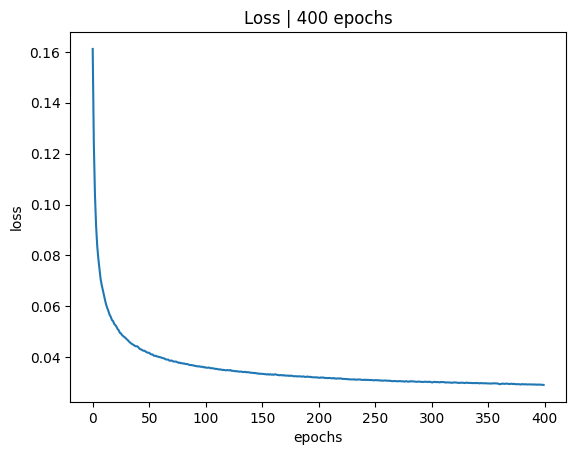

Final loss: 0.029166027903556824


In [ ]:
image_tensor, images, height, width = load_data(data_folder, 'binaryalphadigs.mat')

trained_rbm = []

for batch_size in [1, 5, 10, 50, 100]:

    rbm = RBM(p=image_tensor.size(1), q=128, img_size=(height, width))
    rbm.train(image_tensor, nb_epoch=400, batch_size=batch_size, eps=1e-2, verbose=True)
    trained_rbm.append({"batch_size":batch_size, "rbm": rbm})

>>>>> batch_size = 1
Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


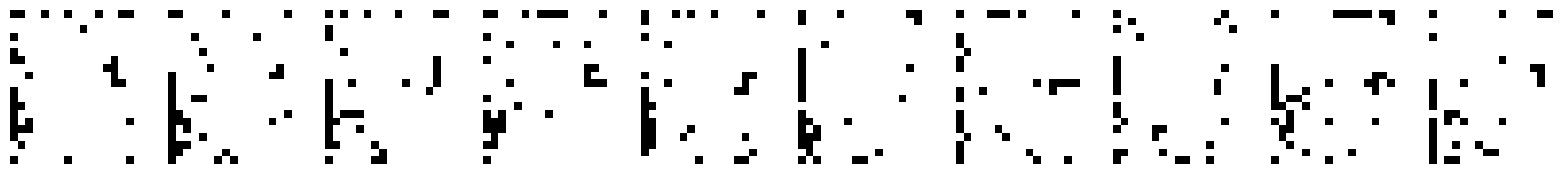

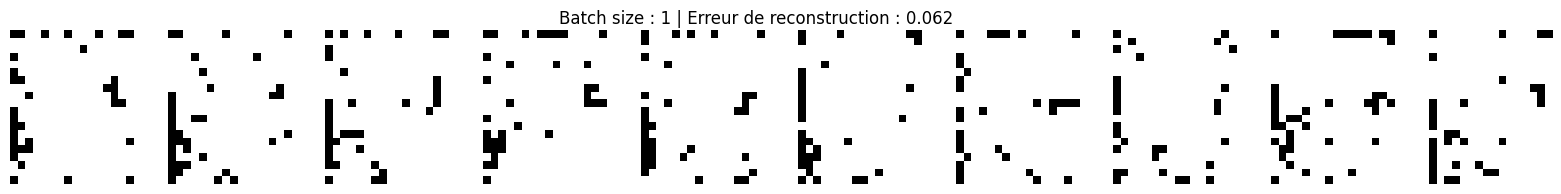

In [145]:
for rbm_ in trained_rbm:
    batch_size = rbm_["batch_size"]
    rbm: RBM = rbm_["rbm"]

    print(f">>>>> batch_size = {batch_size}")

    generated_images = rbm.generer_image_RBM(num_iterations=100000, num_images=10)
    error = rbm.reconstruction_error(generated_images, return_float=True)
    rbm.save_generated_images(generated_images, path=f"assets/rbm_batchsize_{batch_size}.png", title=f"Batch size : {batch_size} | Erreur de reconstruction : {round(error, 3)}")

### 2. Number of Characters to Learn

In [307]:
def image_to_tensor(images: np.ndarray) -> torch.Tensor:
    # Flatten all images across all classes (0-35: 10 digits + 26 letters)
    flattened_images = [img.flatten() for img in images]

    # Convert to a tensor
    image_tensor = torch.tensor(np.array(flattened_images), dtype=torch.float32)
    return image_tensor


#### Only A

Epoch 1/1300, Reconstruction Error (EQ): 0.214103
Epoch 11/1300, Reconstruction Error (EQ): 0.187187
Epoch 21/1300, Reconstruction Error (EQ): 0.186550
Epoch 31/1300, Reconstruction Error (EQ): 0.183115
Epoch 41/1300, Reconstruction Error (EQ): 0.174251
Epoch 51/1300, Reconstruction Error (EQ): 0.158980
Epoch 61/1300, Reconstruction Error (EQ): 0.148587
Epoch 71/1300, Reconstruction Error (EQ): 0.140652
Epoch 81/1300, Reconstruction Error (EQ): 0.134633
Epoch 91/1300, Reconstruction Error (EQ): 0.130963
Epoch 101/1300, Reconstruction Error (EQ): 0.127044
Epoch 111/1300, Reconstruction Error (EQ): 0.123032
Epoch 121/1300, Reconstruction Error (EQ): 0.118528
Epoch 131/1300, Reconstruction Error (EQ): 0.113831
Epoch 141/1300, Reconstruction Error (EQ): 0.108968
Epoch 151/1300, Reconstruction Error (EQ): 0.104693
Epoch 161/1300, Reconstruction Error (EQ): 0.100507
Epoch 171/1300, Reconstruction Error (EQ): 0.096109
Epoch 181/1300, Reconstruction Error (EQ): 0.091672
Epoch 191/1300, Reconst

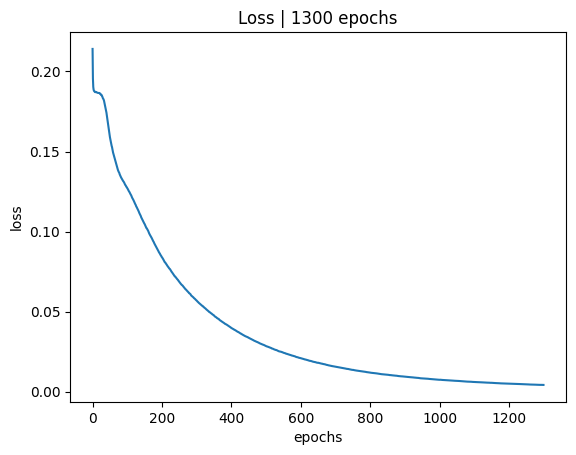

Final loss: 0.00416693277657032


In [319]:
images = lire_alpha_digit(data, [10]) # Only A
image_tensor = image_to_tensor(images)

rbm = RBM(p=image_tensor.size(1), q=128, img_size=(20, 16))

_ = rbm.train(image_tensor, nb_epoch=1300, batch_size=10, eps=1e-2, verbose=True)

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


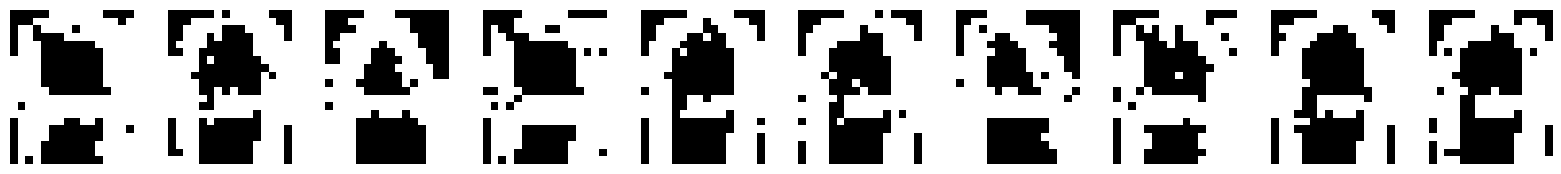

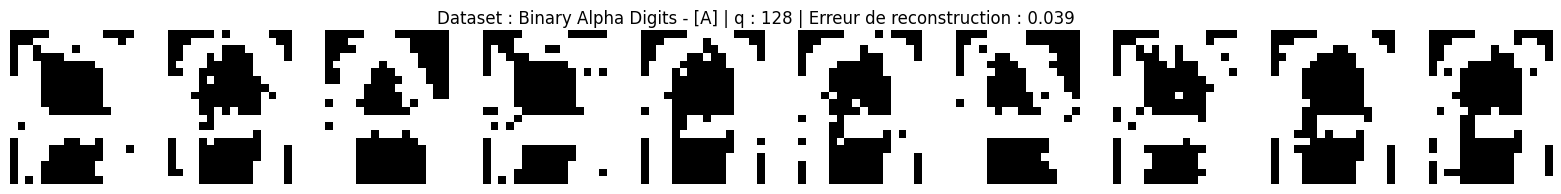

In [320]:
generated_images = rbm.generer_image_RBM(num_iterations=1000, num_images=10)
error = rbm.reconstruction_error(generated_images, return_float=True)
rbm.save_generated_images(generated_images, path=f"assets/BALD_A.png", title=f"Dataset : Binary Alpha Digits - [A] | q : {128} | Erreur de reconstruction : {round(error, 3)}")

#### Try A, AB, ABC, ABCD... A-Z

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


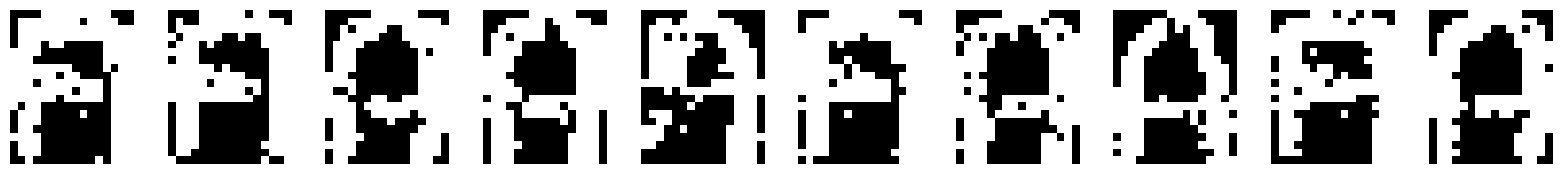

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


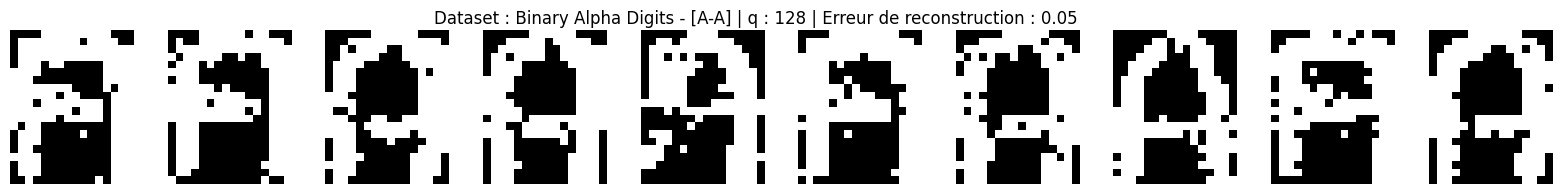

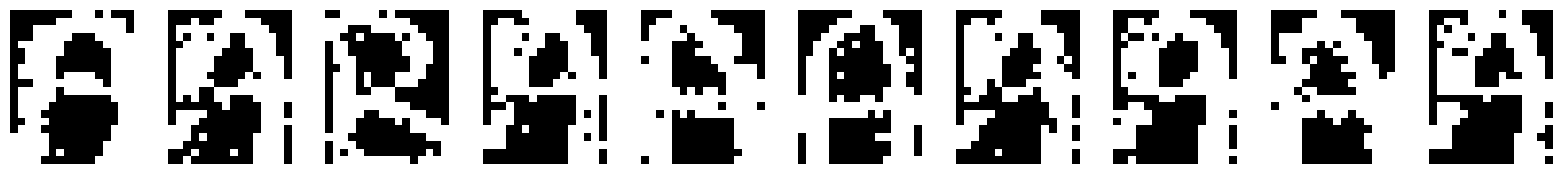

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


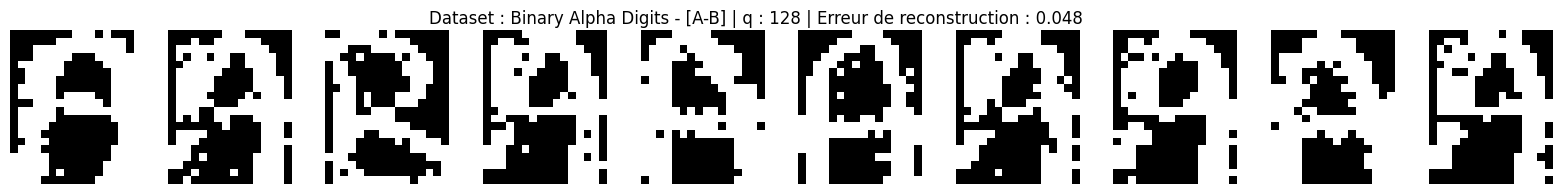

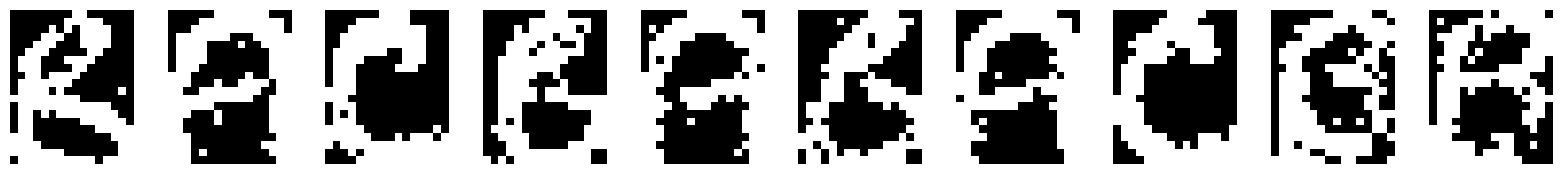

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


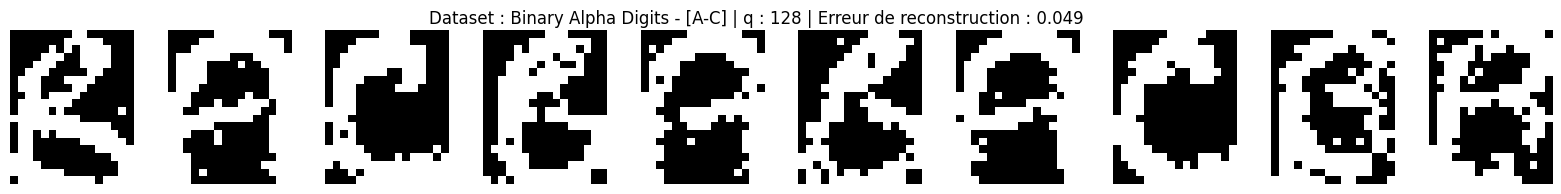

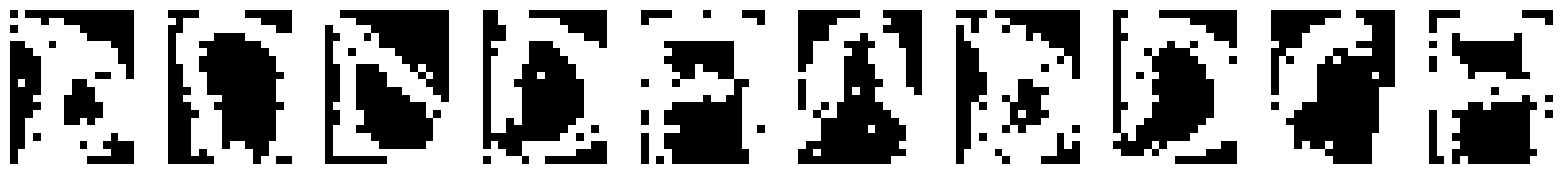

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


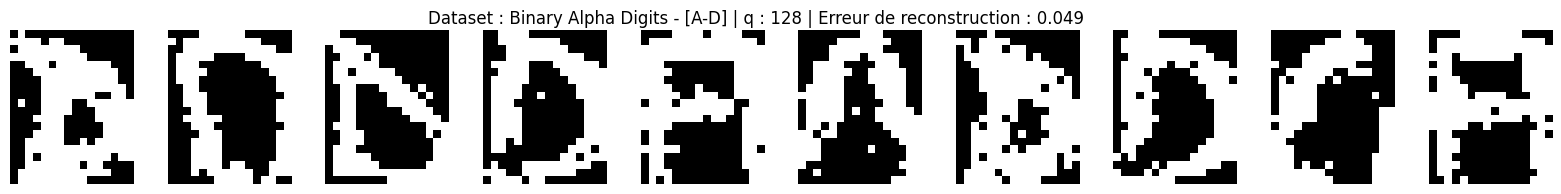

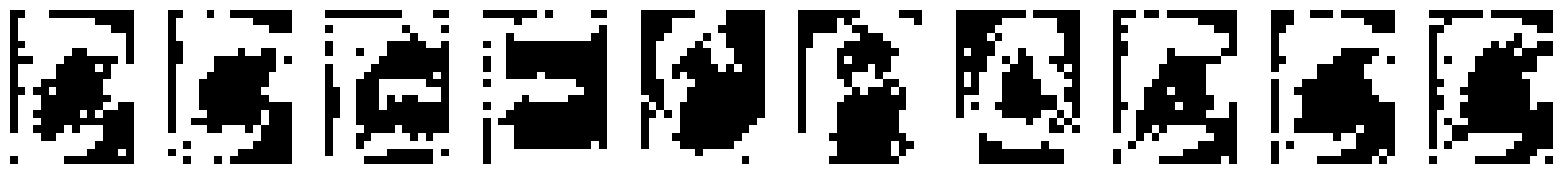

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


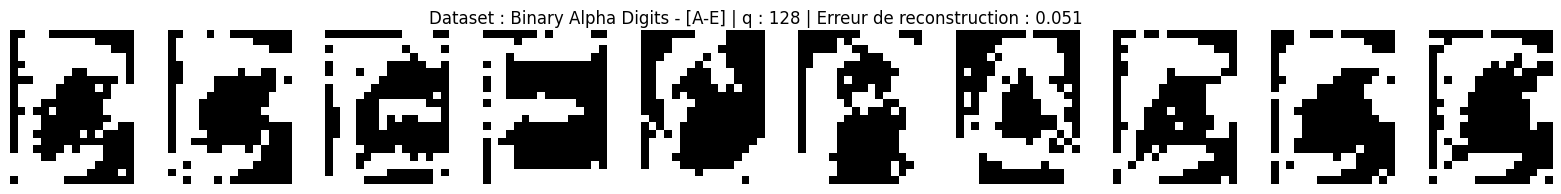

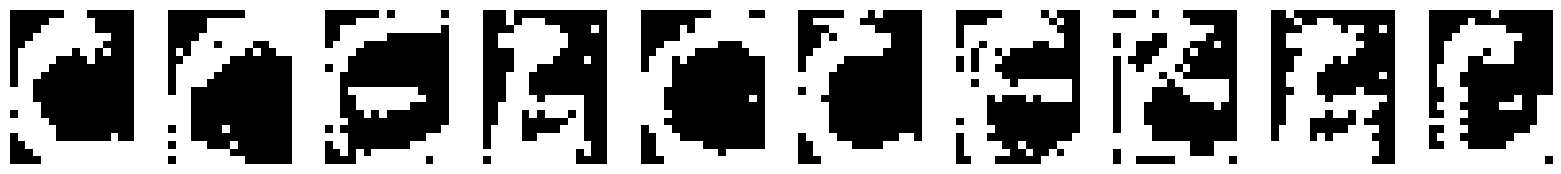

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


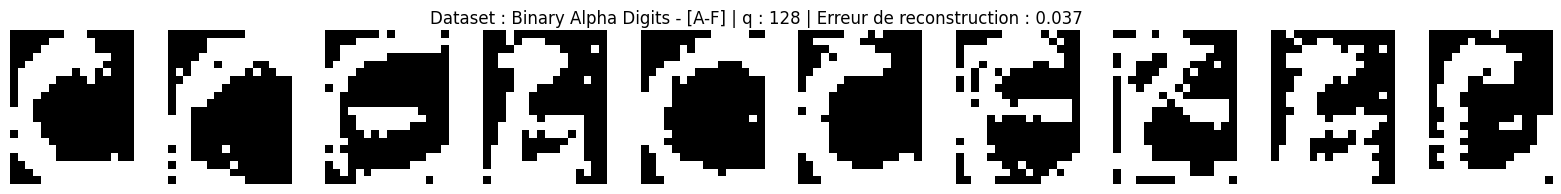

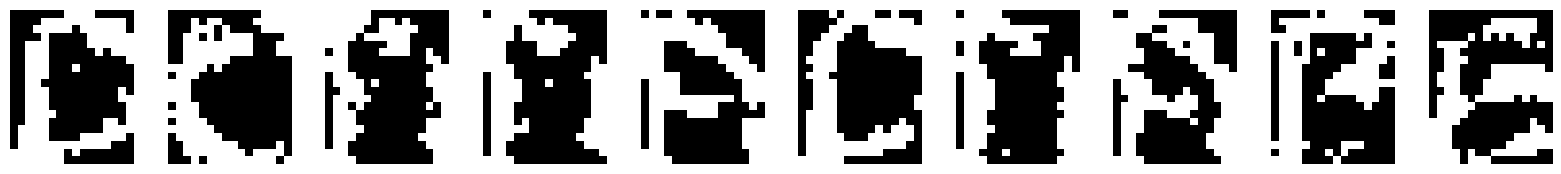

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


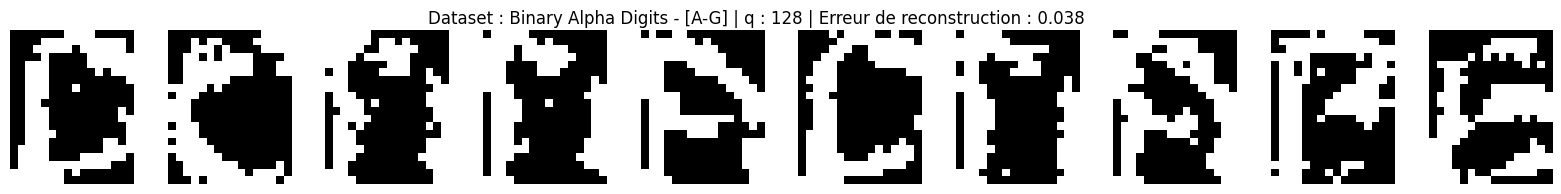

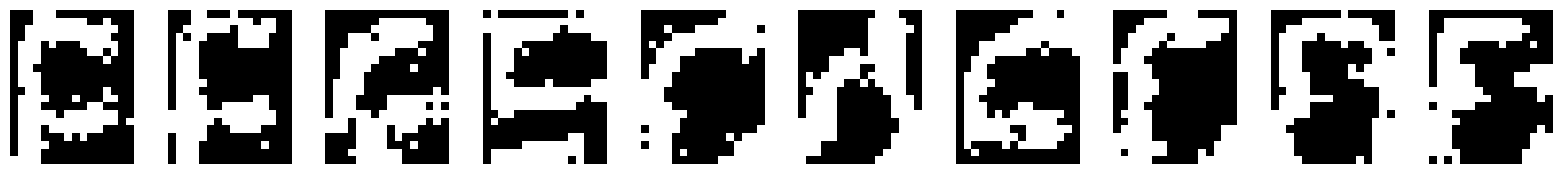

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


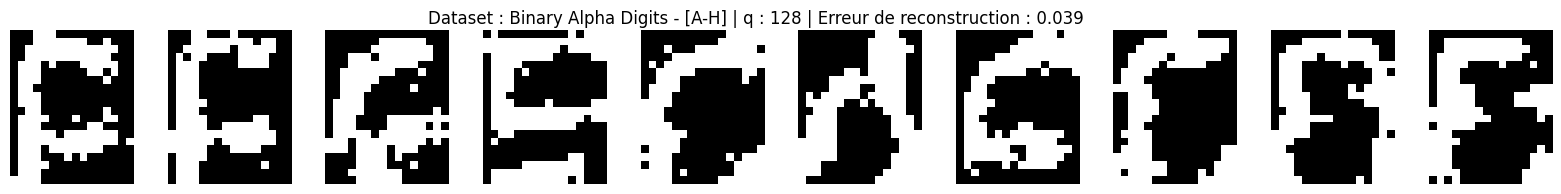

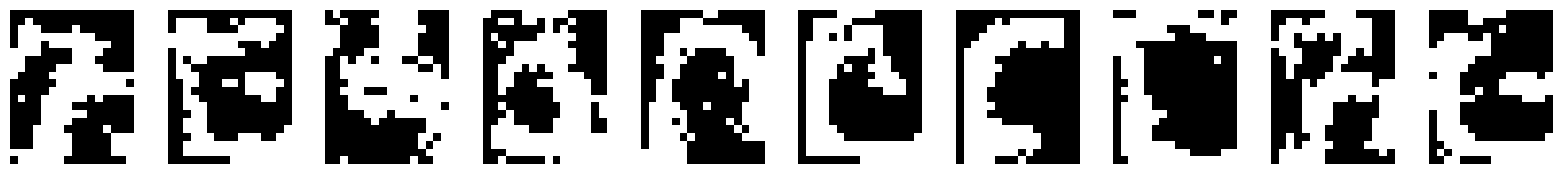

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


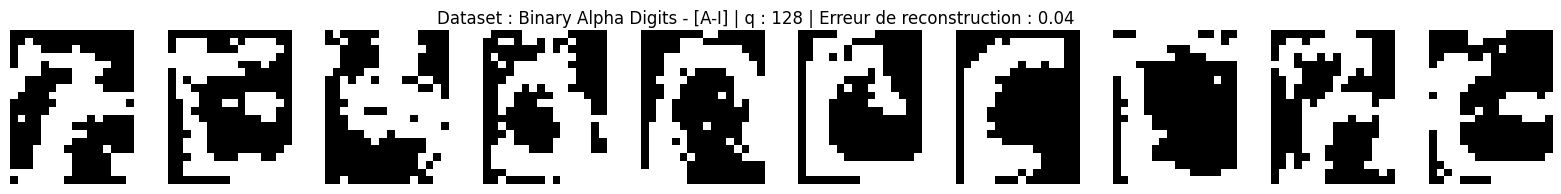

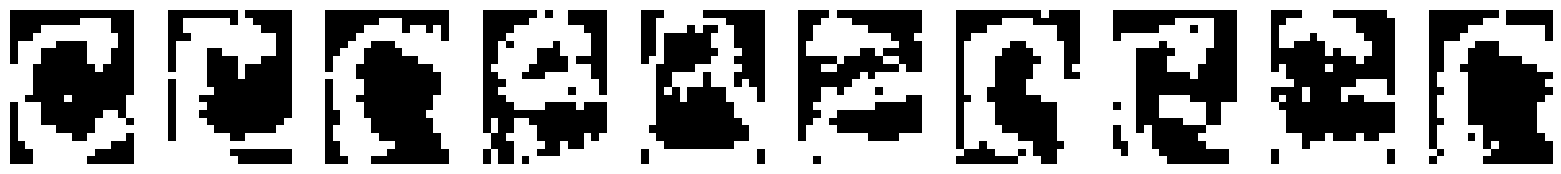

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


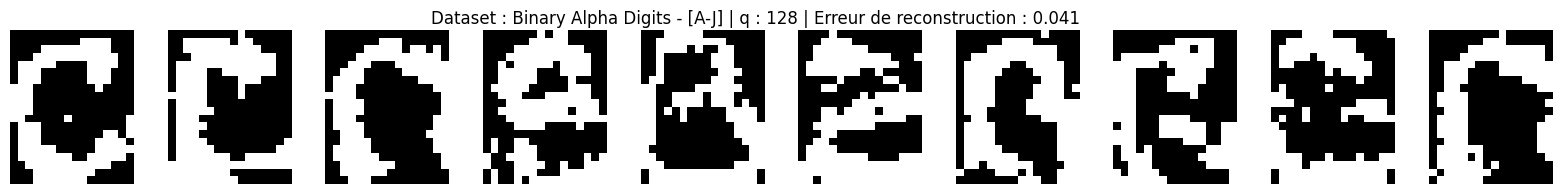

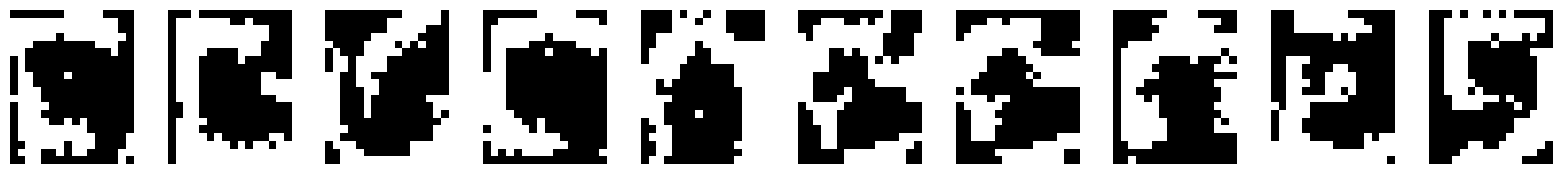

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


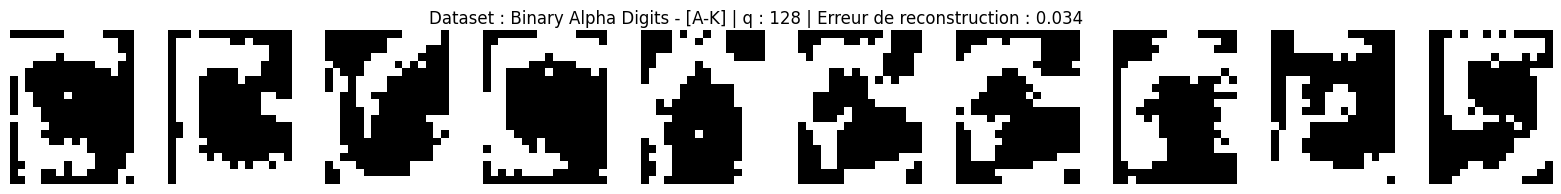

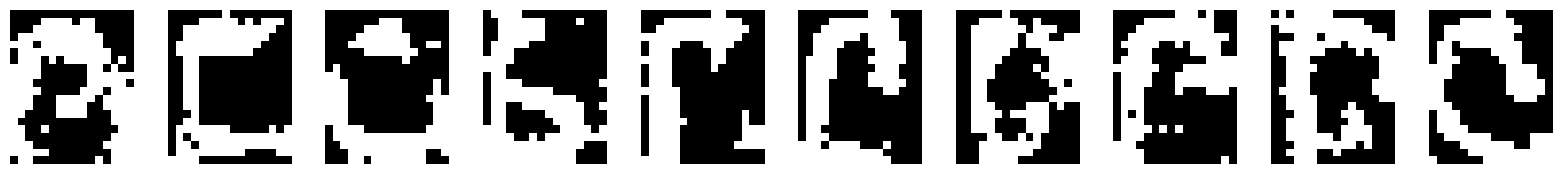

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


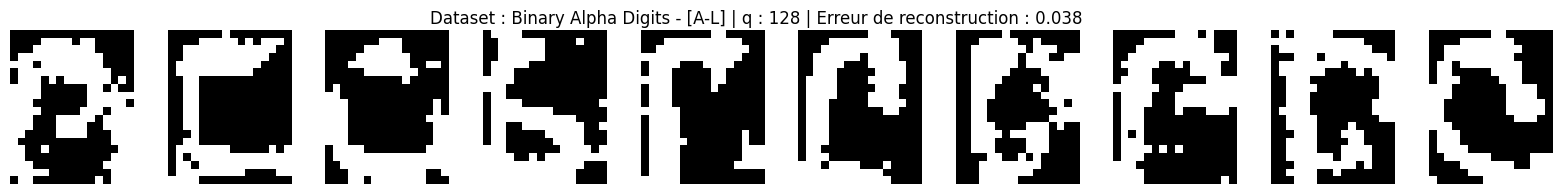

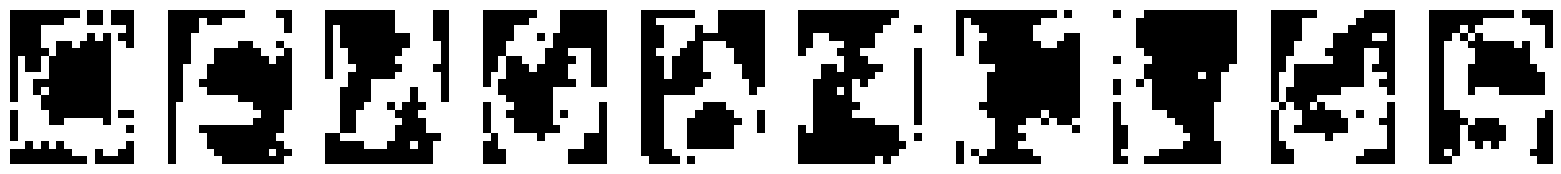

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


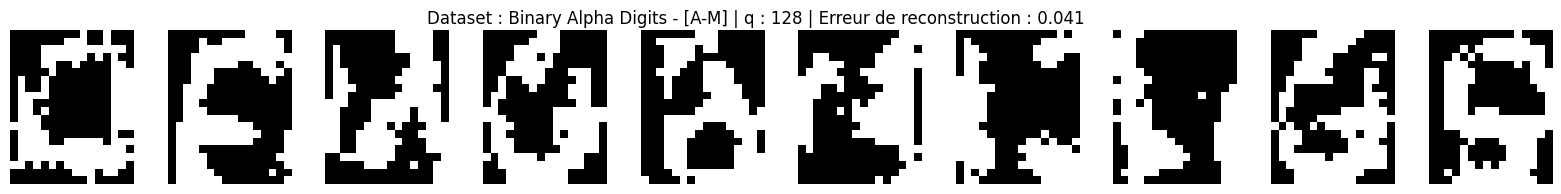

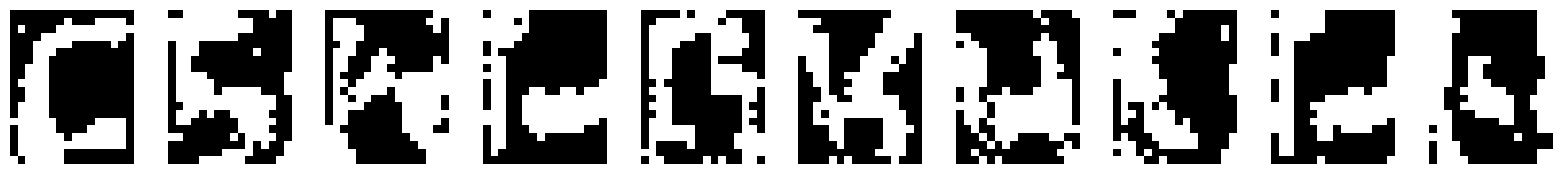

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


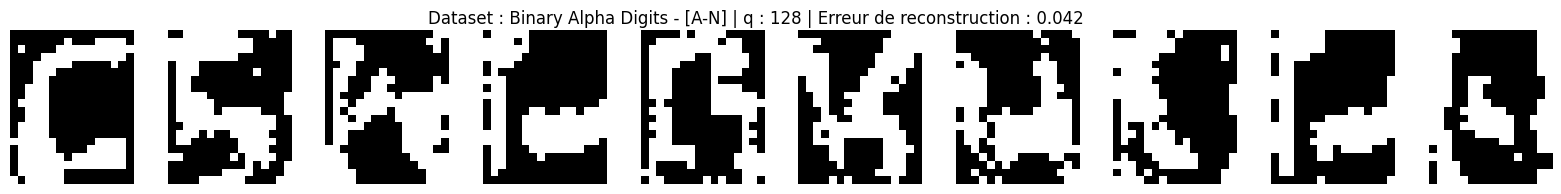

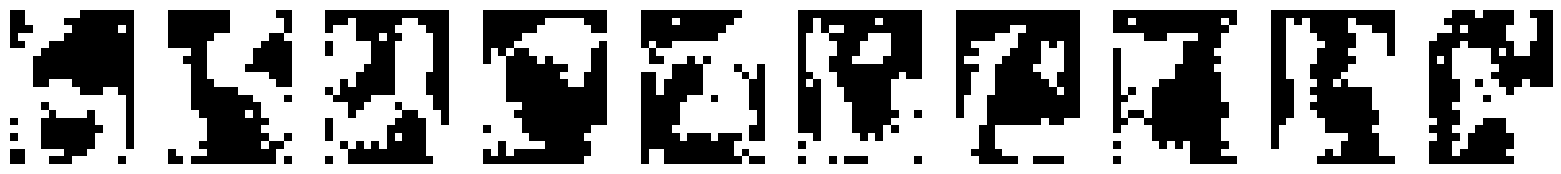

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


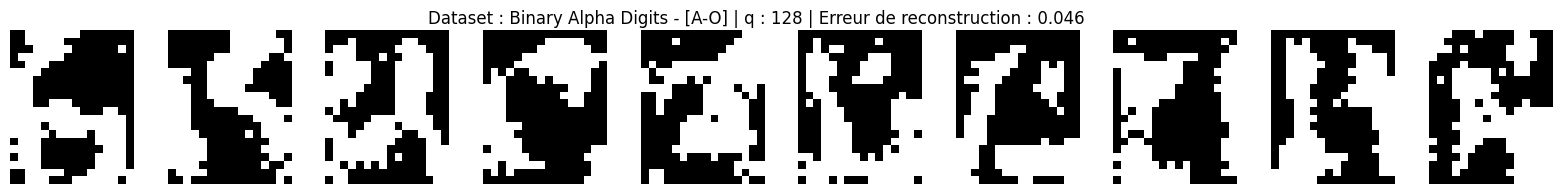

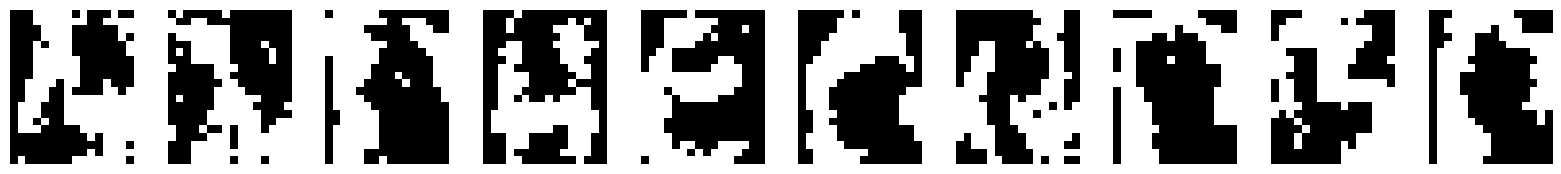

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


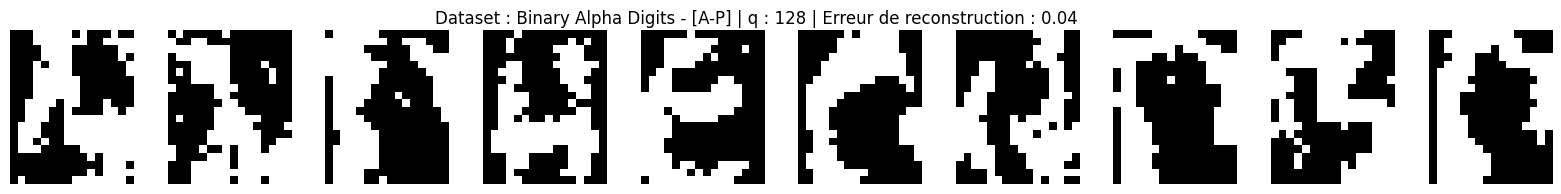

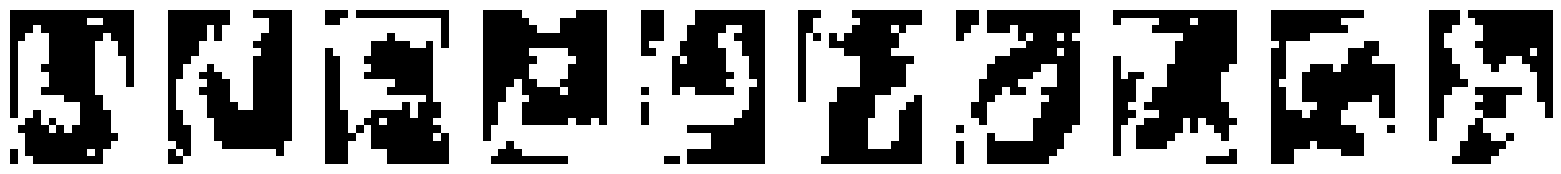

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


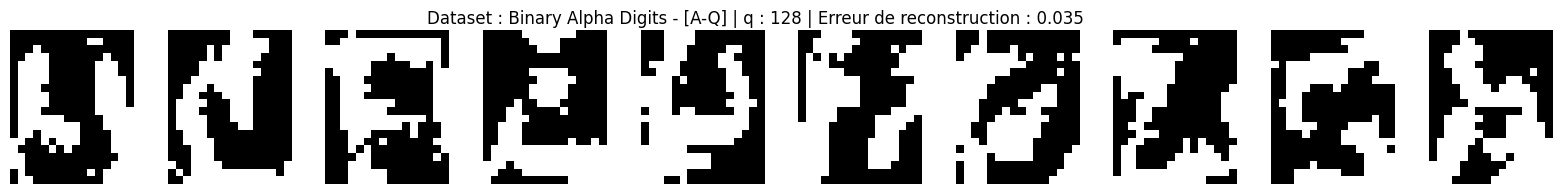

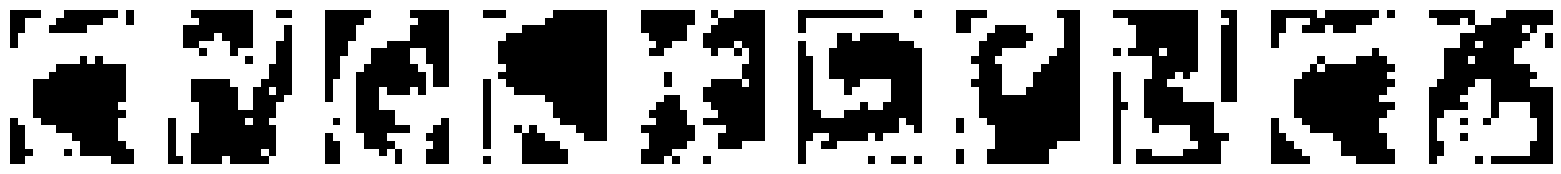

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


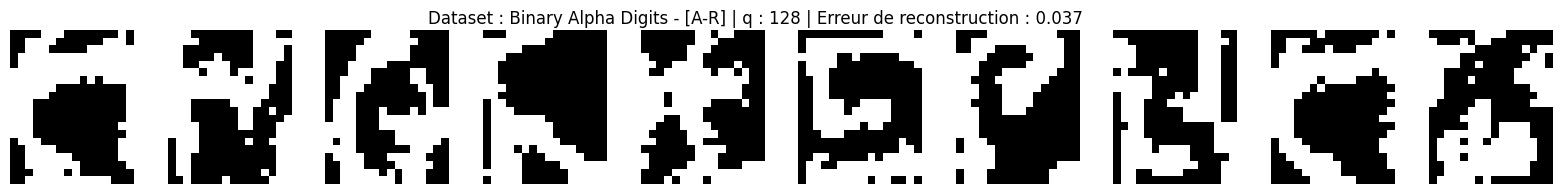

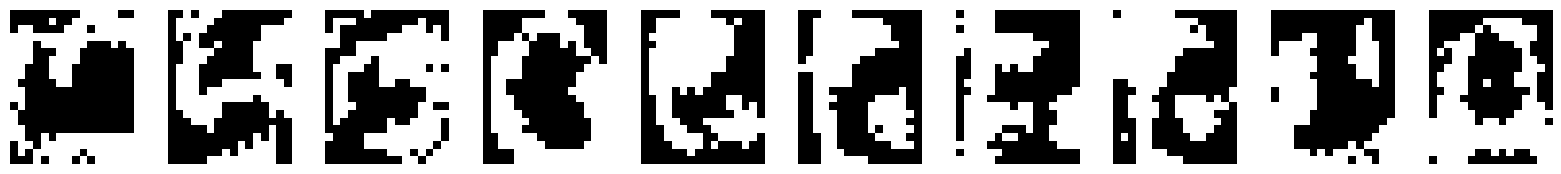

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


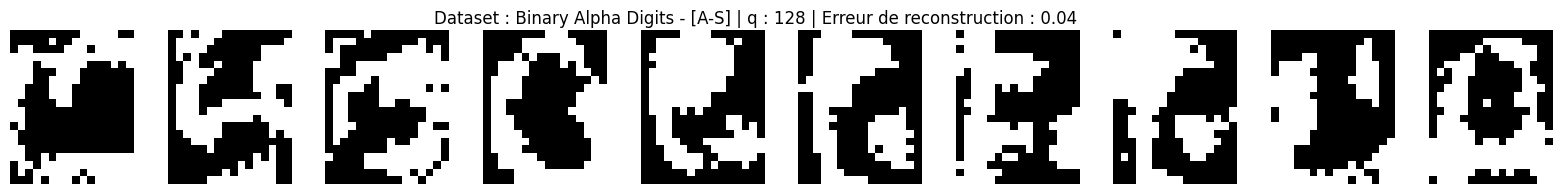

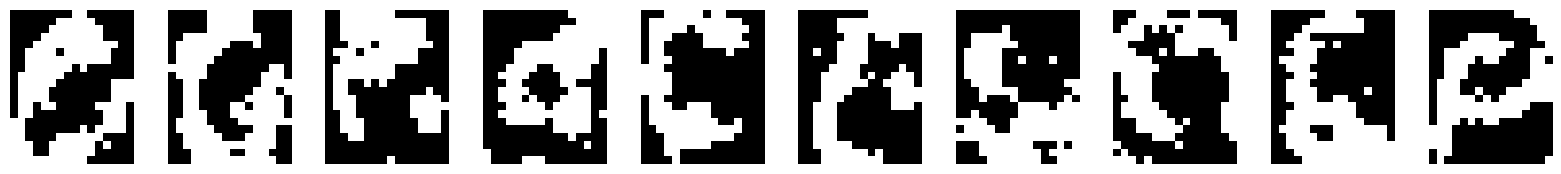

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


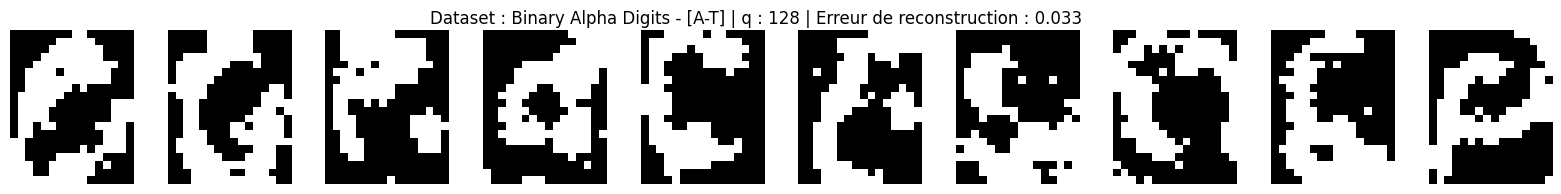

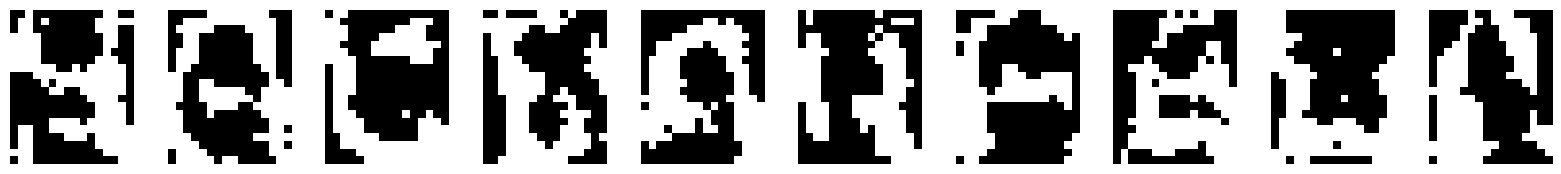

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


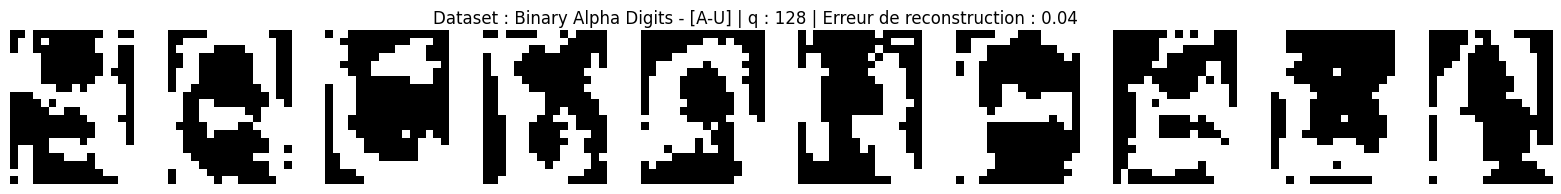

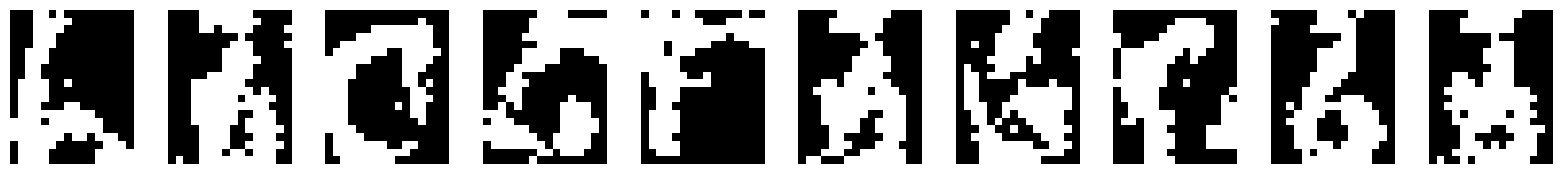

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


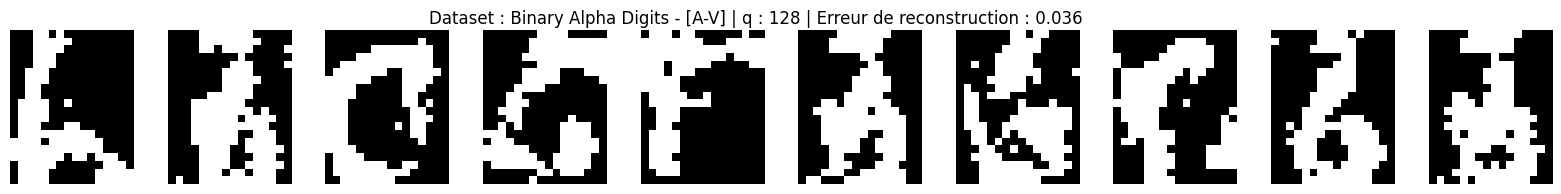

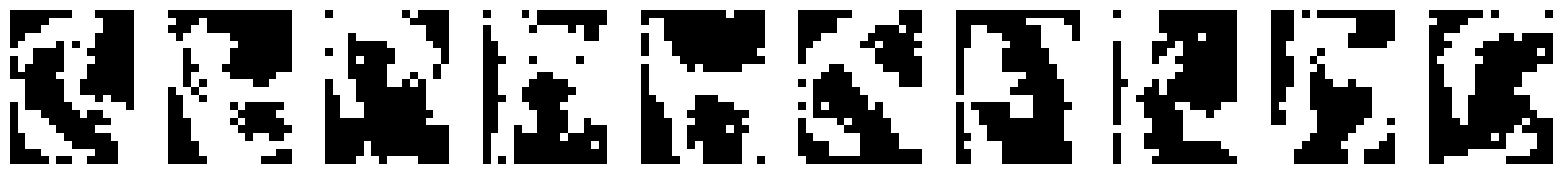

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


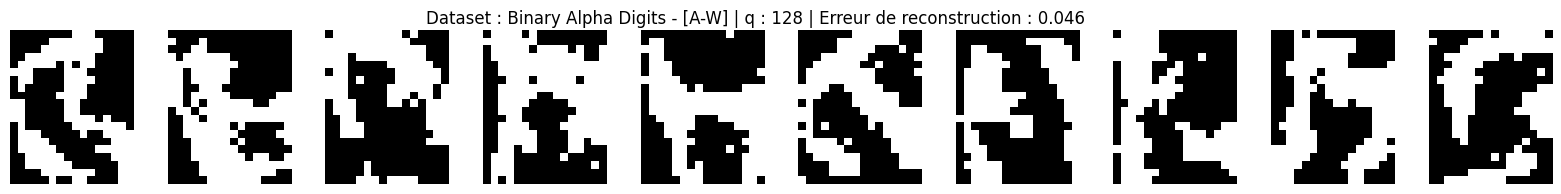

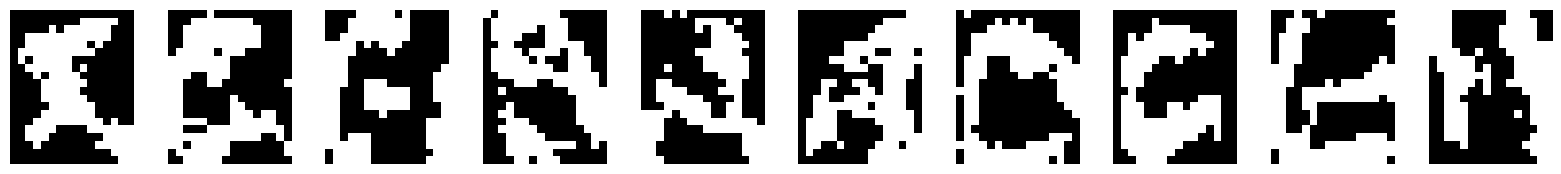

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


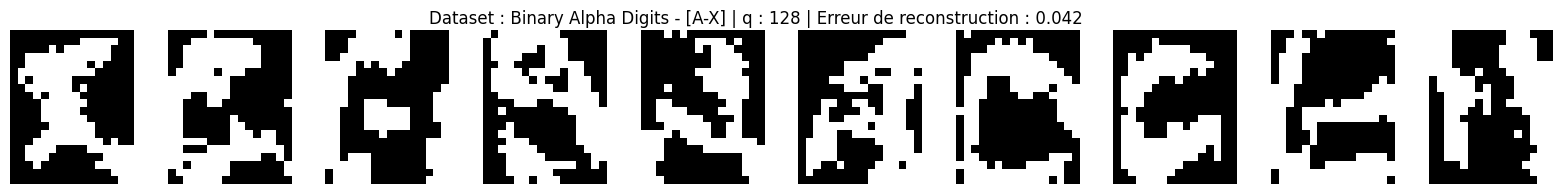

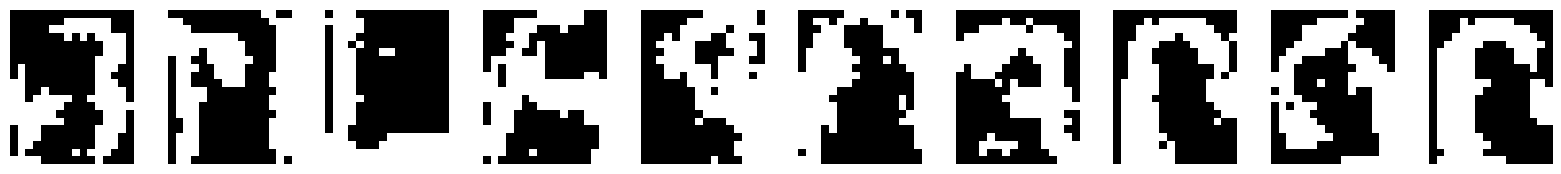

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


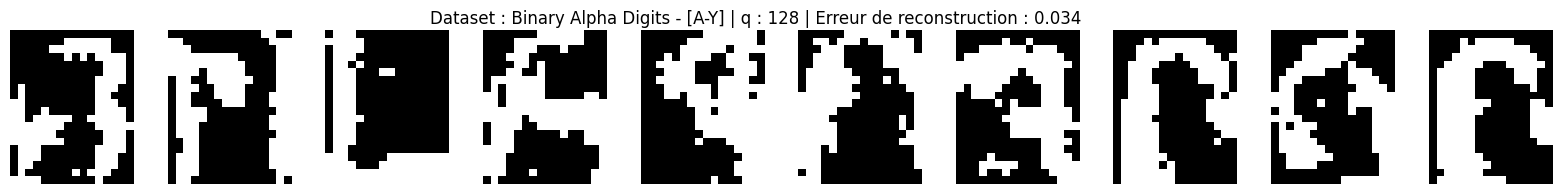

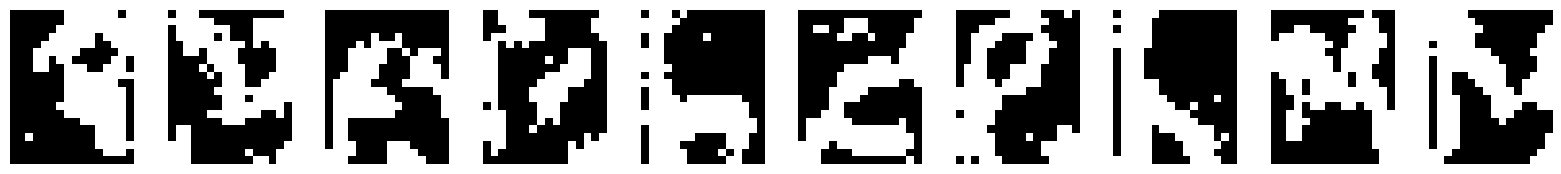

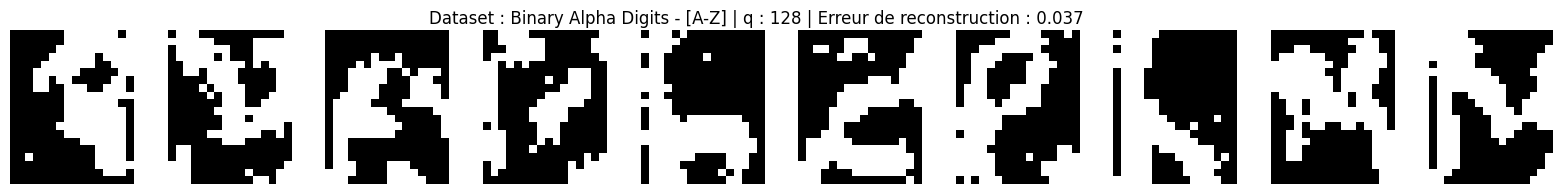

In [337]:
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

list_error = []

for i in range(26):
    
    images = lire_alpha_digit(data, list(range(10, 11+i)))
    image_tensor = image_to_tensor(images)

    rbm = RBM(p=image_tensor.size(1), q=128, img_size=(20, 16))

    rbm.train(image_tensor, nb_epoch=1000, batch_size=10, eps=1e-2, verbose=False)

    generated_images = rbm.generer_image_RBM(num_iterations=1000, num_images=10)
    error = rbm.reconstruction_error(generated_images, return_float=True)
    rbm.save_generated_images(generated_images, path=f"assets/BALD_A-{alphabet[i]}.png", title=f"Dataset : Binary Alpha Digits - [A-{alphabet[i]}] | q : {128} | Erreur de reconstruction : {round(error, 3)}")

    list_error.append(error)

- MNIST

In [282]:
from pathlib import Path

def load_mnist_data(data_folder='./data/mnist-dataset') -> tuple[torch.Tensor, np.ndarray, int, int]:

    folder_path =Path(data_folder)
    train_image_path = folder_path / 'train-images.idx3-ubyte'

    with open(train_image_path, 'rb') as file: 
        data = np.frombuffer(file.read(), dtype = np.uint8)

    # values of pixels : [0-255] -> [0, 1]
    binarized_data = (data > 127).astype(int)

    height, width = 28, 28
    images = binarized_data[16:].reshape(-1, height, width)

    # Keep only 1404 images like in binaryalphadigs dataset
    images: list[np.ndarray] = images[np.random.choice(images.shape[0], 1404, replace=False)]

    flattened_images = [img.flatten() for img in images]

    # Convert to a tensor
    image_tensor = torch.tensor(np.array(flattened_images), dtype=torch.float32)

    return image_tensor, images, height, width


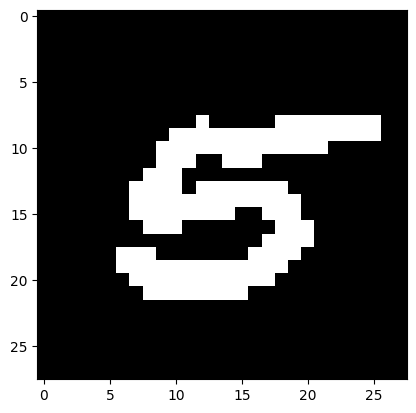

In [285]:
image_tensor, images, height, width = load_mnist_data()

plt.imshow(images[3], cmap='gray')
plt.show()

Epoch 1/400, Reconstruction Error (EQ): 0.225402
Epoch 11/400, Reconstruction Error (EQ): 0.130576
Epoch 21/400, Reconstruction Error (EQ): 0.101576
Epoch 31/400, Reconstruction Error (EQ): 0.088145
Epoch 41/400, Reconstruction Error (EQ): 0.079527
Epoch 51/400, Reconstruction Error (EQ): 0.073539
Epoch 61/400, Reconstruction Error (EQ): 0.069120
Epoch 71/400, Reconstruction Error (EQ): 0.065467
Epoch 81/400, Reconstruction Error (EQ): 0.062529
Epoch 91/400, Reconstruction Error (EQ): 0.060142
Epoch 101/400, Reconstruction Error (EQ): 0.058122
Epoch 111/400, Reconstruction Error (EQ): 0.056301
Epoch 121/400, Reconstruction Error (EQ): 0.054726
Epoch 131/400, Reconstruction Error (EQ): 0.053410
Epoch 141/400, Reconstruction Error (EQ): 0.052015
Epoch 151/400, Reconstruction Error (EQ): 0.051025
Epoch 161/400, Reconstruction Error (EQ): 0.049937
Epoch 171/400, Reconstruction Error (EQ): 0.048940
Epoch 181/400, Reconstruction Error (EQ): 0.048059
Epoch 191/400, Reconstruction Error (EQ): 

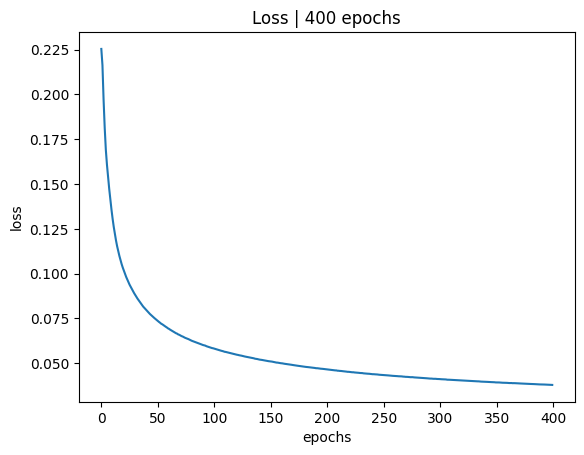

Final loss: 0.03788372874259949


In [235]:
q=128
rbm = RBM(p=image_tensor.size(1), q=q, img_size=(height, width))

_ = rbm.train(image_tensor, nb_epoch=400, batch_size=10, eps=1e-2, verbose=True)

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 320])


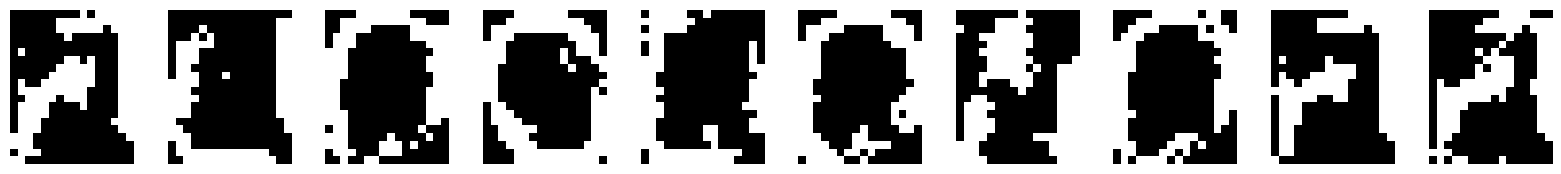

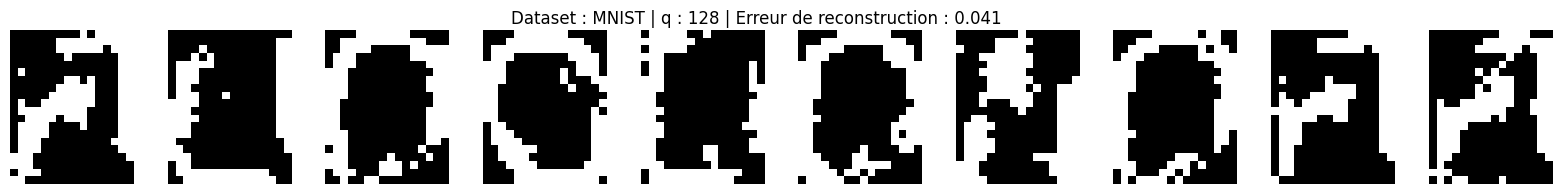

In [240]:
generated_images = rbm.generer_image_RBM(num_iterations=100000, num_images=10)
error = rbm.reconstruction_error(generated_images, return_float=True)
rbm.save_generated_images(generated_images, path=f"assets/mnist.png", title=f"Dataset : MNIST | q : {q} | Erreur de reconstruction : {round(error, 3)}")

- Fashion-MNIST

In [241]:
from pathlib import Path

def load_fashion_mnist_data(data_folder='./data/fashionmnist-dataset') -> tuple[torch.Tensor, np.ndarray, int, int]:

    folder_path =Path(data_folder)
    train_image_path = folder_path / 'train-images-idx3-ubyte'

    with open(train_image_path, 'rb') as file: 
        data = np.frombuffer(file.read(), dtype = np.uint8)

    # values of pixels : [0-255] -> [0, 1]
    binarized_data = (data > 127).astype(int)

    height, width = 28, 28
    images = binarized_data[16:].reshape(-1, height, width)

    # Keep only 1404 images like in binaryalphadigs dataset
    images: list[np.ndarray] = images[np.random.choice(images.shape[0], 1404, replace=False)]

    flattened_images = [img.flatten() for img in images]

    # Convert to a tensor
    image_tensor = torch.tensor(np.array(flattened_images), dtype=torch.float32)

    return image_tensor, images, height, width

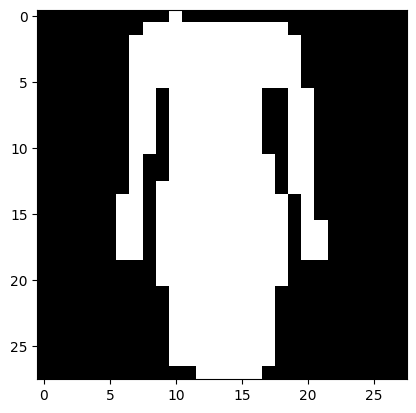

In [245]:
image_tensor, images, height, width = load_fashion_mnist_data()

plt.imshow(images[1], cmap='gray')
plt.show()

Epoch 1/400, Reconstruction Error (EQ): 0.137216
Epoch 11/400, Reconstruction Error (EQ): 0.094558
Epoch 21/400, Reconstruction Error (EQ): 0.082703
Epoch 31/400, Reconstruction Error (EQ): 0.075533
Epoch 41/400, Reconstruction Error (EQ): 0.070028
Epoch 51/400, Reconstruction Error (EQ): 0.065791
Epoch 61/400, Reconstruction Error (EQ): 0.062197
Epoch 71/400, Reconstruction Error (EQ): 0.059144
Epoch 81/400, Reconstruction Error (EQ): 0.056557
Epoch 91/400, Reconstruction Error (EQ): 0.054175
Epoch 101/400, Reconstruction Error (EQ): 0.052267
Epoch 111/400, Reconstruction Error (EQ): 0.050371
Epoch 121/400, Reconstruction Error (EQ): 0.048953
Epoch 131/400, Reconstruction Error (EQ): 0.047535
Epoch 141/400, Reconstruction Error (EQ): 0.046332
Epoch 151/400, Reconstruction Error (EQ): 0.045249
Epoch 161/400, Reconstruction Error (EQ): 0.044210
Epoch 171/400, Reconstruction Error (EQ): 0.043180
Epoch 181/400, Reconstruction Error (EQ): 0.042395
Epoch 191/400, Reconstruction Error (EQ): 

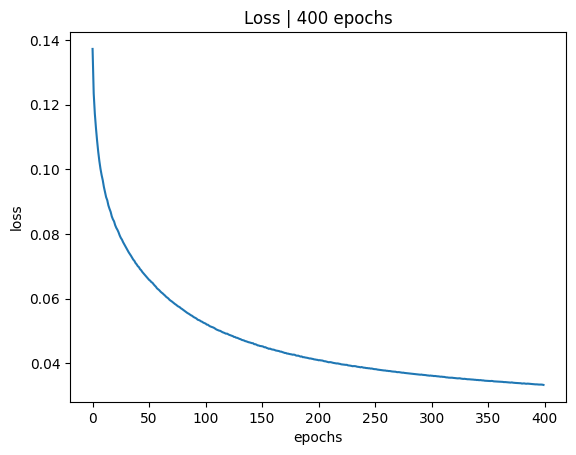

Final loss: 0.033292654901742935


In [246]:
q=128
rbm = RBM(p=image_tensor.size(1), q=q, img_size=(height, width))

_ = rbm.train(image_tensor, nb_epoch=400, batch_size=10, eps=1e-2, verbose=True)

Infos on generated_images:
type: <class 'torch.Tensor'>
size: torch.Size([10, 784])


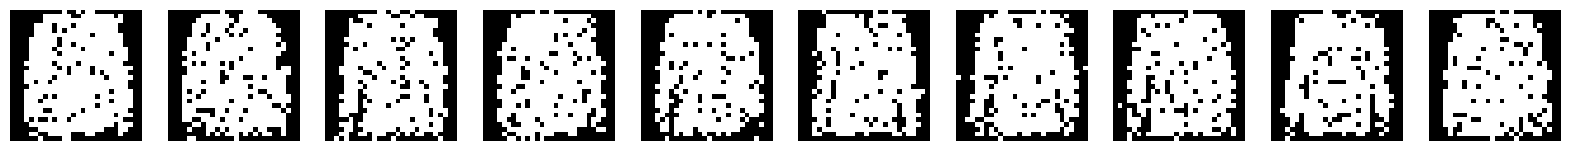

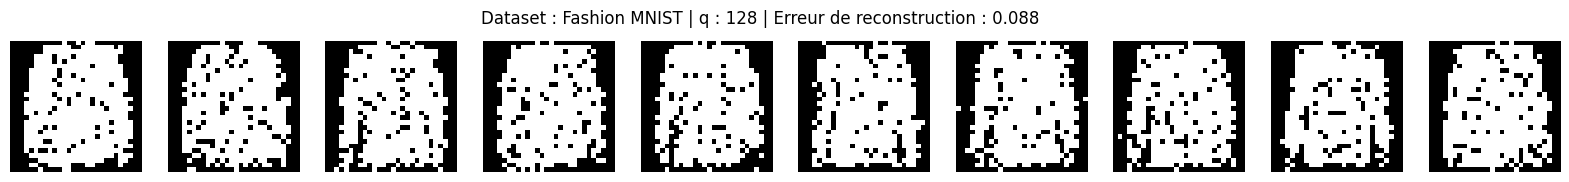

In [258]:
generated_images = rbm.generer_image_RBM(num_iterations=100000, num_images=10)
error = rbm.reconstruction_error(generated_images, return_float=True)
rbm.save_generated_images(generated_images, path=f"assets/fashion_mnist.png", title=f"Dataset : Fashion MNIST | q : {q} | Erreur de reconstruction : {round(error, 3)}")

### 4. Try other models

- GAN

In [255]:
import torch
import torchvision
from torch.optim import Adam
import torch.utils.data as data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchgan
from torchgan.models import DCGANGenerator, DCGANDiscriminator
from torchgan.losses import MinimaxGeneratorLoss, MinimaxDiscriminatorLoss
from torchgan.trainer import Trainer

In [256]:
def cifar10_dataloader():
    train_dataset = dsets.CIFAR10(root='./cifar10', train=True,
                                  transform=transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))]),
                                  download=True)
    train_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    return train_loader

In [257]:
trainer = Trainer({"generator": {"name": DCGANGenerator, "args": {"out_channels": 3, "step_channels": 16}, "optimizer": {"name": Adam, "args": {"lr": 0.0002, "betas": (0.5, 0.999)}}},
                   "discriminator": {"name": DCGANDiscriminator, "args": {"in_channels": 3, "step_channels": 16}, "optimizer": {"name": Adam, "args": {"lr": 0.0002, "betas": (0.5, 0.999)}}}},
                  [MinimaxGeneratorLoss(), MinimaxDiscriminatorLoss()],
                  sample_size=512, epochs=1)

trainer(cifar10_dataloader())

AssertionError: Torch not compiled with CUDA enabled